# Bag of Words exercise

The goal of this exercise is to train a classifier using as input Bag of Words features extracted from SIFT features. You can either run this notebook on your own computer (this is probably the fastest option) or using google colab.

The code workflow is as follows: First, an image dataset (Caltech-101) with 101 classes is downloaded. Then, SIFT features are extracted to train a BoW codebook. Once the codebook is obtained, we train a classifier (in the provided example, SVM) using as input the BoW features to get the class of the images.

Please complete the code marked with TODO, and then try to improve the evaluation accuracy. Finally, answer the questions at the end of this notebook.

First, we import all required libraries.

In [87]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
import cv2 as cv

Load Caltech101 dataset


In [88]:
(raw_train, raw_test), metadata = tfds.load(
    'caltech101',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
)
print(metadata)

tfds.core.DatasetInfo(
    name='caltech101',
    full_name='caltech101/3.0.2',
    description="""
    Caltech-101 consists of pictures of objects belonging to 101 classes, plus one
    `background clutter` class. Each image is labelled with a single object. Each
    class contains roughly 40 to 800 images, totalling around 9k images. Images are
    of variable sizes, with typical edge lengths of 200-300 pixels. This version
    contains image-level labels only. The original dataset also contains bounding
    boxes.
    """,
    homepage='https://doi.org/10.22002/D1.20086',
    data_dir='/Users/daniel/tensorflow_datasets/caltech101/3.0.2',
    file_format=tfrecord,
    download_size=131.05 MiB,
    dataset_size=132.86 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=102),
    }),
    supervised_keys=('image', 'label'),
    

Preprocess the dataset to batch convert all images into grayscale and get  train/test maps.

In [89]:
def preprocess(image, label):
  # Convert to grayscale
  image = tf.image.rgb_to_grayscale(image)
  return image, label

train = raw_train.map(preprocess)
test = raw_test.map(preprocess)

Visualization of a training image

2024-01-12 17:06:56.449418: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


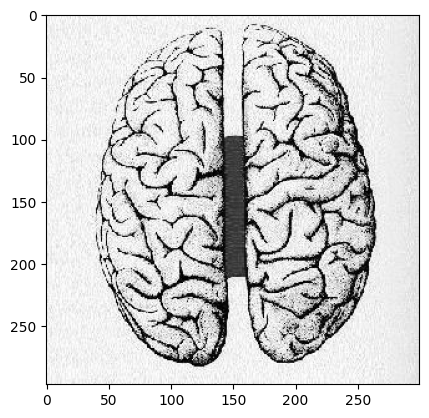

In [90]:
def viewSampleImage(train):
  sample = next(iter(train))

  image, label = sample
  plt.imshow(image, cmap='gray')

viewSampleImage(train)

Method to get the SIFT features from an image

In [91]:
def getSIFTFeatures(image):
   with tf.compat.v1.Session() as sess:
      # Compat necessary to convert from tf array into opencv array
      imagecv = image.numpy()
      imagecv = imagecv.astype(np.uint8)

      # Asegúrate de que la imagen sea un array de NumPy
      imagecv = np.array(image)

      # Convertir a uint8 si es necesario
      imagecv = imagecv.astype(np.uint8)

      # Verifica si la imagen es a color (tiene 3 canales)
      if len(imagecv.shape) == 3 and imagecv.shape[2] == 3:
         # Convertir imagen a escala de grises
         gray = cv.cvtColor(imagecv, cv.COLOR_BGR2GRAY)
      else:
         # Si la imagen ya está en escala de grises
         gray = imagecv

      # Initialize SIFT detector
      sift = cv.SIFT_create()

      # Detect and compute SIFT features
      keypoints, descriptors = sift.detectAndCompute(gray, None)

   return descriptors


Some BoW parameters can be tuned.

In [92]:
# Params for clustering

# TODO: After all the code is completed and working, you can try with different values for k and batch size to improve the accuracy
k = 500
batch_size = 1000

The following method extracts all SIFT descriptors from the images and train a BoW

In [93]:
def trainBOW(data):
    BOW = []

    print("Extracting SIFT descriptors from images...")
    for image, label in tqdm(data):

      SIFTdescriptors = getSIFTFeatures(image)

      if SIFTdescriptors is not None:
        for d in SIFTdescriptors:
          BOW.append(d)

    print("Training BoW...")
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=True).fit(BOW)

    return kmeans

We call the previous method to train the BOW


In [94]:
kmeans = trainBOW(train)

Extracting SIFT descriptors from images...


100%|██████████| 3060/3060 [00:26<00:00, 114.17it/s]


Training BoW...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Init 1/3 with method k-means++
Inertia for init 1/3: 312113239.0
Init 2/3 with method k-means++
Inertia for init 2/3: 311663997.0
Init 3/3 with method k-means++
Inertia for init 3/3: 311366508.0
[MiniBatchKMeans] Reassigning 119 cluster centers.
Minibatch step 1/139674: mean batch inertia: 102596.736
Minibatch step 2/139674: mean batch inertia: 88081.7567056016, ewa inertia: 88081.7567056016
Minibatch step 3/139674: mean batch inertia: 82917.80568533667, ewa inertia: 88074.36242516861
Minibatch step 4/139674: mean batch inertia: 81394.63637463264, ewa inertia: 88064.79770090237
Minibatch step 5/139674: mean batch inertia: 79227.84367295481, ewa inertia: 88052.14403397184
Minibatch step 6/139674: mean batch inertia: 78615.29532754973, ewa inertia: 88038.63137564779
Minibatch step 7/139674: mean batch inertia: 77958.2675921682, ewa inertia: 88024.19726572129
Minibatch step 8/139674: mean batch inertia: 78212.35341696611, ewa inertia: 88010.14765047558
Minibatch step 9/139674: mean batch 

Once trained, we can call the following method to extract the BoW descriptor for any image

In [95]:
def extractBOWDescriptors(kmeans, data):
    print('Extracting BOW descriptors')

    BOWDescriptors = []
    labels = []

    for image, label in tqdm(data):
        descriptors = getSIFTFeatures(image)
        if descriptors is not None:
            histo = np.zeros(k)  # Inicializa el histograma con ceros

            # Añade los descriptores de la imagen a la lista
            ad = [d for d in descriptors]

            # Predice el índice del clúster para cada descriptor
            clusterIndices = kmeans.predict(ad)

            # Actualiza el histograma con los índices de los clústeres
            for i in clusterIndices:
                histo[i] += 1

        # Normalizar el histograma aquí si es necesario
        # histo = histo / np.linalg.norm(histo)

        # Añade el descriptor BoW y la etiqueta de la imagen a las listas
        BOWDescriptors.append(histo)
        labels.append(label)

    return BOWDescriptors, labels


We extract the BOW descriptors from the training set

In [96]:
BOWDescriptors, labels = extractBOWDescriptors(kmeans, train)

Extracting BOW descriptors


100%|██████████| 3060/3060 [00:27<00:00, 110.74it/s]


Given the BoW descriptors, we can train any machine learning method to get the class of an image. We also store the model weights to load them afterward.

In [97]:
def trainSVM(descriptors, labels):
    # Parametrización del clasificador SVM
    svm = cv.ml.SVM_create()
    svm.setType(cv.ml.SVM_C_SVC)
    svm.setKernel(cv.ml.SVM_LINEAR)

    # Configurar los criterios de terminación
    criteria = cv.TERM_CRITERIA_MAX_ITER
    max_iter = 100
    epsilon = 1e-5
    svm.setTermCriteria((criteria, max_iter, epsilon))

    # Entrenar SVM
    svm.train(np.array(descriptors, dtype='float32'), cv.ml.ROW_SAMPLE, np.array(labels, dtype='int'))

    # Guardar el modelo
    svm.save('modelSVM.xml')


In [98]:
trainSVM(BOWDescriptors, labels)

To perform the evaluation, we extract the BoW descriptors of all images in the test set and print the accuracy. Note that there are 101 classes, so the random guess accuracy is around 1%. Therefore, more than a 30% would be an excellent result.

In [99]:
def testSIFT(kmeans, data):

    # Extract BOW test descriptors
    descBOWTest, labels = extractBOWDescriptors(kmeans, data)

    # Load trained model
    svm = cv.ml.SVM_load('modelSVM.xml')

    # Classify test samples
    print('Classifying test samples...')

    npDescriptors = np.array(descBOWTest, dtype='float32')
    results = svm.predict(npDescriptors)

    # Obtain the results
    ok = 0.0
    i = 0
    for pred in results[1]:
        if pred == labels[i]:
            ok += 1
        i += 1

    print('Accuracy=', ok/len(labels))

In [100]:
testSIFT(kmeans, test)

Extracting BOW descriptors


100%|██████████| 6084/6084 [01:04<00:00, 93.65it/s] 


Classifying test samples...
Accuracy= 0.3328402366863905


Finally, please answer the following:

- Discuss the accuracy results and the describe the tests you made


Resultados de Precisión: El clasificador muestra una precisión del 33.28%, lo cual se considera bajo para muchas aplicaciones. Este rendimiento puede estar influenciado por factores como la calidad y cantidad de los datos, el balance de clases, los parámetros del modelo (para KMeans en BoW y para SVM), y las técnicas de preprocesamiento y extracción de características (como SIFT). Se sugiere una comparación con otros modelos y técnicas para evaluar si la baja precisión es específica del enfoque actual o un problema más amplio relacionado con los datos o la tarea en sí.





- Is BoW a supervised or unsupervised technique? Explain why...


Naturaleza de BoW: Bag of Words (BoW) es una técnica no supervisada para la extracción de características, que se basa en agrupar descriptores visuales (generalmente con KMeans) sin considerar las etiquetas de las imágenes. Aunque es no supervisada en su proceso de creación de características, BoW se emplea comúnmente en contextos supervisados, como al entrenar un clasificador SVM con los descriptores BoW. Esto demuestra cómo una técnica no supervisada puede ser parte integral de un flujo de trabajo supervisado.